<a href="https://colab.research.google.com/github/fadheladlansyah/Fashion_Segmentation/blob/master/kelvin_imaterialist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fadheladlansyah/Fashion_Segmentation/blob/master/eda.ipynb)

reference : https://www.kaggle.com/pednoi/training-mask-r-cnn-to-be-a-fashionista-lb-0-07

## Kaggle access

In [0]:
## Install Kaggle library
# !pip uninstall -y kaggle
# !pip install --upgrade pip
# !pip install kaggle==1.5.6
# !kaggle -v

## Upload kaggle API key file
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [0]:
## Auth with our Kaggle Account
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Download Dataset

In [0]:
## Download dataset
!kaggle competitions download -c imaterialist-fashion-2019-fgvc6 -p ./data --force

100% 19.1G/19.1G [05:21<00:00, 70.8MB/s]
100% 19.1G/19.1G [05:21<00:00, 63.8MB/s]


*   iMaterialist 2020: belum bisa diakses. Akses sesudah kompetisi berakhir tanggal 28 Mei 2020.
*   iMaterialist 2019: tidak bisa download semua image data. belum tahu caranya.
*   iMaterialist 2018: not applicable. kasus deteksi



In [0]:
## Unzip the dataset
#!unzip data/*.zip

## Config Dataset

In [0]:
## Config our library
import os

ROOT_DIR = '/content'
DATA_DIR = os.path.join(ROOT_DIR, 'data1')
DATA_TRAIN_DIR = os.path.join(DATA_DIR, 'train')
DATA_TEST_DIR = os.path.join(DATA_DIR, 'test')

In [52]:
## Check directory 
os.listdir(DATA_DIR)  

['train',
 'train.csv',
 'sample_submission.csv',
 'test',
 'label_descriptions.json']

In [0]:
# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512

In [0]:
## Set FashionConfig Object
class FashionConfig(Config):

    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1 
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

## ARRANGE DATASET

In [0]:
import numpy as np
import pandas as pd
import random

import cv2
import os
import json

In [0]:
## 1) Load File
## a. Label Desc(json)
with open(os.path.join(DATA_DIR,'label_descriptions.json')) as f:
    label_descriptions = json.load(f)

## b. Train segmentation (csv)
segment_df = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))

In [0]:
## 2) Get Label Name
label_names = [x['name'] for x in label_descriptions['categories']]

## 
multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.47%


In [68]:
## Create Category ID ??
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0].astype(int)

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [0]:
## Create feature is_upper(upper+wholebody)
"""
class id vs super category 
0-5 upper
6-8 lower
9-12 wholebody
13-45 asesoris
"""
segment_df["is_upper"] = [1 if 0<=n<=5 or 9<=n<=12 else 0 for n in segment_df["CategoryId"]]

In [72]:
segment_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId,is_upper
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6,0
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0,1
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28,0
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31,0
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32,0


In [86]:
## Create New df with Grouping
## kaggle notebook's
# image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
# size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
# image_df = image_df.join(size_df, on='ImageId')

## Mine
upper_only_df = segment_df[segment_df['is_upper']==1]
upper_image_df = upper_only_df.groupby('ImageId')['EncodedPixels','CategoryId'].agg(lambda x: list(x))
size_df = upper_only_df.groupby('ImageId')['Height', 'Width'].mean()
upper_image_df = upper_image_df.join(size_df, on='ImageId')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [90]:
image_df = upper_image_df
upper_image_df.head()

,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6323163 11 6328356 32 6333549 53 6338742 75 6...,"[0, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[1343707 9 1346138 27 1348569 44 1351000 62 13...,[1],2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2287509 4 2290504 12 2290588 26 2293501 18 22...,[10],3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,[10],567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,[10],750,500


In [92]:
available_images = [f for f in os.listdir(DATA_TRAIN_DIR) if f[-3:]=='jpg']
image_df_try = pd.DataFrame()
for image in list(image_df.index):
  if image in available_images:
    image_df_try = image_df_try.append(image_df.loc[image])

image_df_try.head()

,CategoryId,EncodedPixels,Height,Width
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,"[0, 4]",[6323163 11 6328356 32 6333549 53 6338742 75 6...,5214.0,3676.0
0000fe7c9191fba733c8a69cfaf962b7.jpg,[1],[1343707 9 1346138 27 1348569 44 1351000 62 13...,2448.0,2448.0
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[10],[2287509 4 2290504 12 2290588 26 2293501 18 22...,3000.0,1997.0
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[10],[435 132 1002 132 1569 132 2136 132 2703 132 3...,567.0,400.0
0004467156e47b0eb6de4aa6479cbd15.jpg,[10],[132663 8 133396 25 134130 41 134868 53 135611...,750.0,500.0


In [0]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str('/content/data1/train/' + row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(int(info['height']*info['width']), 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((int(info['height']), int(info['width'])), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

In [106]:
image_df_try

,CategoryId,EncodedPixels,Height,Width
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,"[0, 4]",[6323163 11 6328356 32 6333549 53 6338742 75 6...,5214.0,3676.0
0000fe7c9191fba733c8a69cfaf962b7.jpg,[1],[1343707 9 1346138 27 1348569 44 1351000 62 13...,2448.0,2448.0
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[10],[2287509 4 2290504 12 2290588 26 2293501 18 22...,3000.0,1997.0
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[10],[435 132 1002 132 1569 132 2136 132 2703 132 3...,567.0,400.0
0004467156e47b0eb6de4aa6479cbd15.jpg,[10],[132663 8 133396 25 134130 41 134868 53 135611...,750.0,500.0
...,...,...,...,...
fff8d9bd5ad4354b66355dd797942b42.jpg,[10],[408993 3 410489 8 411985 13 413481 19 414977 ...,1500.0,1000.0
fffb65463df408e308983ef743b77491.jpg,[1],[2224221 3 2227216 8 2230211 13 2233206 18 223...,3000.0,2247.0
fffc631acce2e28e1628de685d40c980.jpg,[10],[210058 15 211030 18 212002 21 212974 24 21394...,975.0,650.0
fffe20b555b98c3c1f26c8dfff275cbc.jpg,"[4, 0]",[2062254 2 2065252 8 2068250 13 2071208 29 207...,3000.0,2001.0


In [107]:
image_id

6620

('/content/data1/train/f05d69d0aea0d1a22b2dc4604ca43b72.jpg', ['dress'])


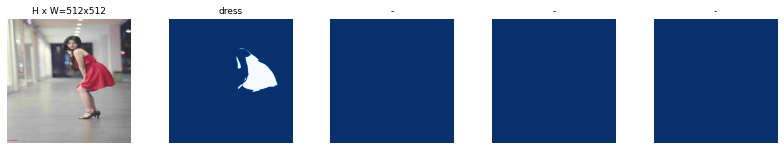

('/content/data1/train/f95a0c17be818a0cf5f5e78c3709865f.jpg', ['top, t-shirt, sweatshirt'])


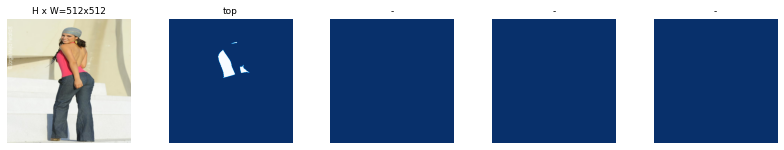

('/content/data1/train/2d6e3a9a53039686f96e4fcd4ee34e08.jpg', ['shirt, blouse'])


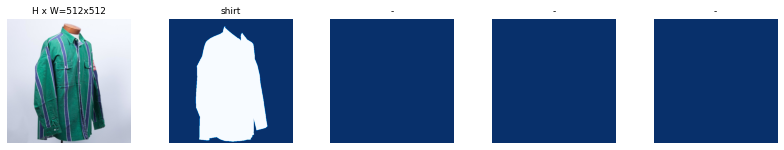

('/content/data1/train/fa255d7b0afc31b653f0bee461767387.jpg', ['shirt, blouse'])


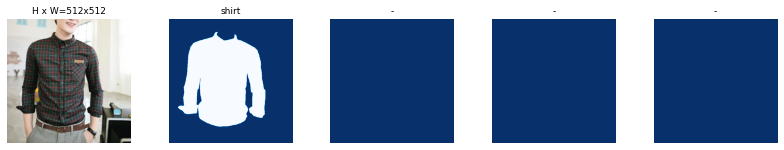

('/content/data1/train/2d0da07fd35dd80ba3eea4b078e8fcb3.jpg', ['dress'])


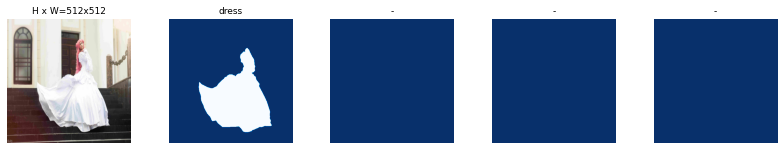

('/content/data1/train/b4ec264fd3660d2cb86da8b3866f35ac.jpg', ['dress'])


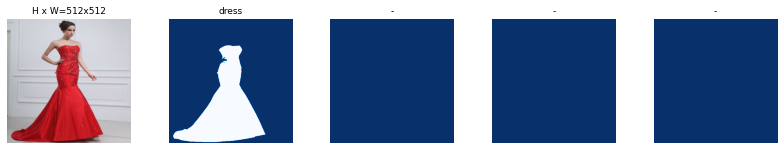

In [109]:
dataset = FashionDataset(image_df_try)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)